In [1]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

warnings.simplefilter(action='ignore', category=FutureWarning)

2024-05-18 13:34:24.387395: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 13:34:24.622560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 13:34:24.622683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 13:34:24.651795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 13:34:24.714511: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_pickle("data/data_original.pkl")

down_sample_percentage = 0.01

# down sample data
df = df.sample(frac=down_sample_percentage/100, random_state=1)

# rename emotions to label and map to integers
df.rename(columns={'emotions':'label'}, inplace = True)
label_map = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5} 
df['label'] = df['label'].map(label_map)

print(df.shape)
df.head()

(42, 2)


,text,label
98790,i wanted them to feel now i feel as though i a...,0
18398,i found myself feeling very sympathetic toward...,2
139349,ive been feeling pretty good today and tonight...,1
13416,i can use to cover my ass when i feel inadequate,0
22297,i feel like ive pissed myself again,3


In [3]:
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

# using prompt engineering to generate a template for the model to fill in with the predicted emotion
def guessEmotion(phrase):
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    generator = pipeline('text-generation', model='gpt2')
    set_seed(42)
    
    template = f"Of the 6 emotions (sadness, joy, love, anger, fear, surprise) the one more prevalent in the phrase '{phrase}' is:" 
    generated_text = generator(template, max_length=100, num_return_sequences=1)[0]['generated_text']
    
    # Analyze the generated text to determine the predicted emotion
    for emotion in emotions:
        if emotion in generated_text.lower()[len(template):]:
            return emotion
    
    return "Unknown"

def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show()


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
df['predicted'] = df['text'].apply(guessEmotion)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=

In [5]:
print(f"Number of 'Unknown' predictions: {df[df['predicted'] == 'Unknown'].shape[0]}")

Number of 'Unknown' predictions: 0


In [6]:
df.head(20)

,text,label,predicted
98790,i wanted them to feel now i feel as though i a...,0,fear
18398,i found myself feeling very sympathetic toward...,2,anger
139349,ive been feeling pretty good today and tonight...,1,fear
13416,i can use to cover my ass when i feel inadequate,0,sadness
22297,i feel like ive pissed myself again,3,fear
13762,i feel a little rebellious,3,anger
85074,i have found myself increasingly down and not ...,1,fear
16669,i decided to put together a quick post today t...,0,fear
80066,i like to pray a decade whenever im feeling st...,0,fear
18670,i could be feeling this unease from a sense of...,1,fear


In [7]:
# add unknown to label_map
label_map["Unknown"] = 6
df['predicted'] = df['predicted'].map(label_map)

/home/sparks/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.21428571428571427
Precision: 0.35294117647058826
Recall: 0.2962962962962963
F1: 0.19634313055365685


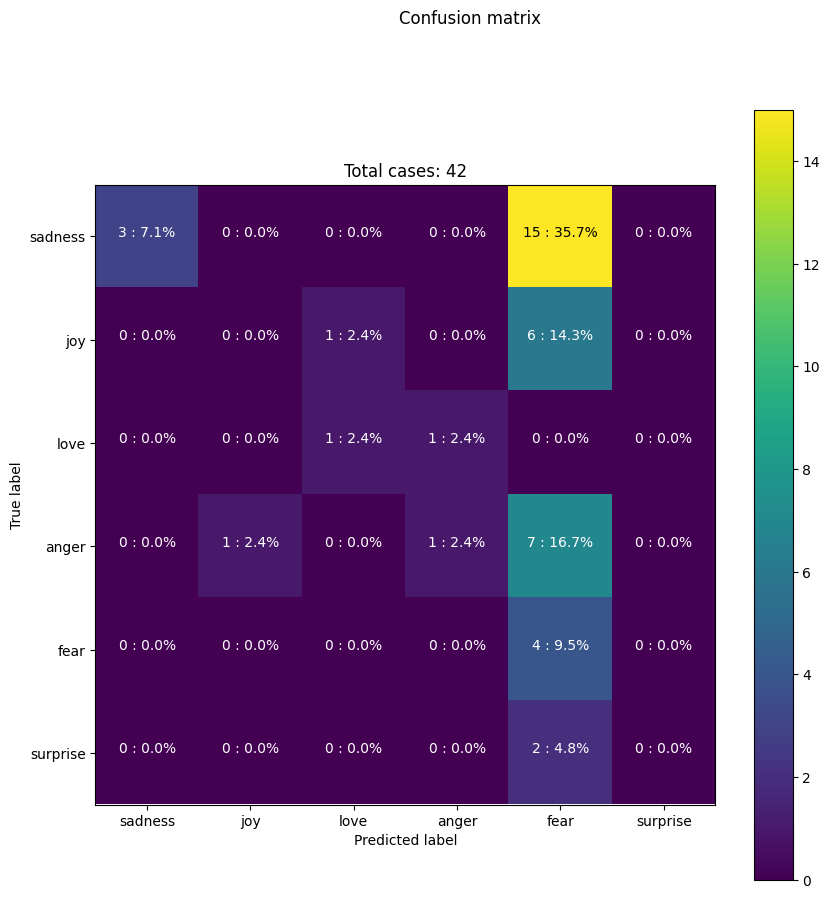

In [8]:
# compare predicted and true labels, calculate accuracy, precision, recall, f1 and confusion matrix
accuracy = accuracy_score(df['label'], df['predicted'])
precision = precision_score(df['label'], df['predicted'], average='macro')
recall = recall_score(df['label'], df['predicted'], average='macro')
f1 = f1_score(df['label'], df['predicted'], average='macro')
confusion = confusion_matrix(df['label'], df['predicted'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
show_cm(confusion, ["sadness", "joy", "love", "anger", "fear", "surprise"])